# Variational Autoencoders

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import sklearn

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl


## Fashion MNIST

In [0]:
from tensorflow.keras.datasets import fashion_mnist

In [6]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# float 32 and scale to 0 - 1
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

print(x_train.shape, x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


A custom layer to sample the codings

\begin{align}
\sigma and 
\mu
\end{align}

In [0]:
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.models import Model

In [0]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 10

# functional API

# input layer
inputs = Input(shape=[28, 28])
# flatten input
z = Flatten()(inputs)
# Dense 1
z = Dense(150, activation='selu')(z)
# Dense 2
z = Dense(100, activation='selu')(z)

# split into 'codings_mean' and 'codings_log_var'
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)

codings = Sampling()([codings_mean, codings_log_var])

# variational encoder
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# decoder
decoder_inputs = Input(shape=[codings_size])
# Dense 1
x = Dense(100, activation='selu')(decoder_inputs)
# Dense 2
x = Dense(150, activation='selu')(x)
# Dense 3
x = Dense(28 * 28, activation='sigmoid')(x)
# Reshape into 28 * 28
outputs = Reshape(target_shape=[28, 28])(x)

# variational decoder
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

# variational auto-encoder
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])



In [0]:
# Latent Loss

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1
)

variational_ae.add_loss(K.mean(latent_loss)/784.0)


In [0]:
# compile

variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [14]:
# train

history = variational_ae.fit(x_train, x_train, epochs=100, batch_size=128,
                             validation_data = [x_test, x_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 89us/sample - loss: 0.3866 - val_loss: 0.3491
Epoch 2/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.3412 - val_loss: 0.3398
Epoch 3/100
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3313 - val_loss: 0.3315
Epoch 4/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.3264 - val_loss: 0.3287
Epoch 5/100
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3233 - val_loss: 0.3240
Epoch 6/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.3212 - val_loss: 0.3225
Epoch 7/100
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3197 - val_loss: 0.3213
Epoch 8/100
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3185 - val_loss: 0.3213
Epoch 9/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.31

In [0]:
# RECONSTRUCTIONS Utility function

def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.gray()
plt.show()

In [0]:
def show_reconstructions(model, images=x_test, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
plt.show()

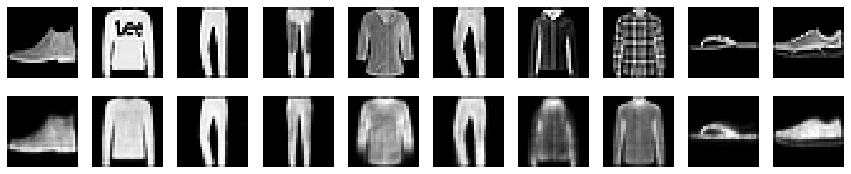

In [38]:
show_reconstructions(variational_ae)
plt.show()

## Generate new Images

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(12, 6))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

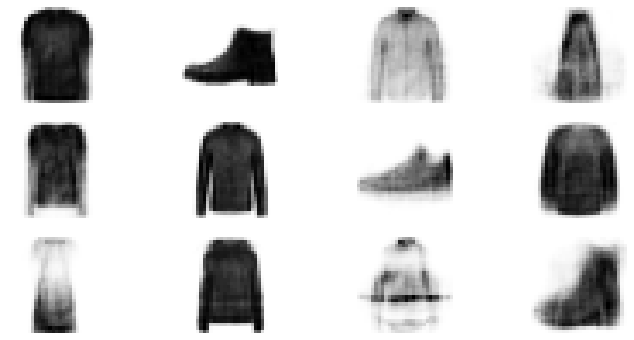

In [50]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])

images = variational_decoder(codings).numpy()

plot_multiple_images(images, 4)

### Experiments

In [51]:
x_train.shape

(60000, 28, 28)

In [0]:
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)

In [55]:
x_train_tensor.shape

TensorShape([60000, 28, 28])

In [58]:
x_train_tensor.dtype

tf.float32